# Naming Trend Between Dog, Baby and Adult: Project Workflow and Report

## Group 6 - ChiaYu Hu & Vanny Yeh

### Topic: 
#### What is the trend of people naming their babies in each race? Do baby's names correlate with adult's name? Do people give their baby the same name as their fur baby? Interested phenomenon between them? 

### Project Description: 

Inspired by the "Big Bang Theory", Sheldon named his son using his best friend's name. We decide to make an analysis of the naming trends in US. 

"What makes a good baby name?" Sometimes people name their babies with their names. Besides, will people name their fur babies just like naming their human babies? 

The project analyses two relationships. First, analyze the relationship between the most popular baby names and most popular adult names in each race (White, Black, Hispanic and Asian). Second, we analyze the popular dog names and the popular baby names. The goal of the project is to determine if the adult names influence the dog and baby's naming trend. 


### GitHub Info:

Username: chiayuandvanny <br>
Repository: https://github.com/chiayuandvanny/DataWranglingProject.git

### Project Notes of Using Data:

The federal Office of Management and Budget (OMB) and the United States Census Bureau define race and ethnicity as separate and distinct identities. Therefore, we would like to inform that we waive some race and ethnicity groups to demonstrate our results more clearly at this point because the collecting data we have is flattened, lumped and inconsistent. Therefore, we merge the races into four groups: "White", "Black", "Hispanic", and "Asian". 

### Dataset Sources:

#### [1] Dog names in NYC:
https://www.kaggle.com/new-york-city/nyc-dog-names <br> 
This dataset was found and provided by Kaggle. It covers dog names and the counts of each name. 
<div>
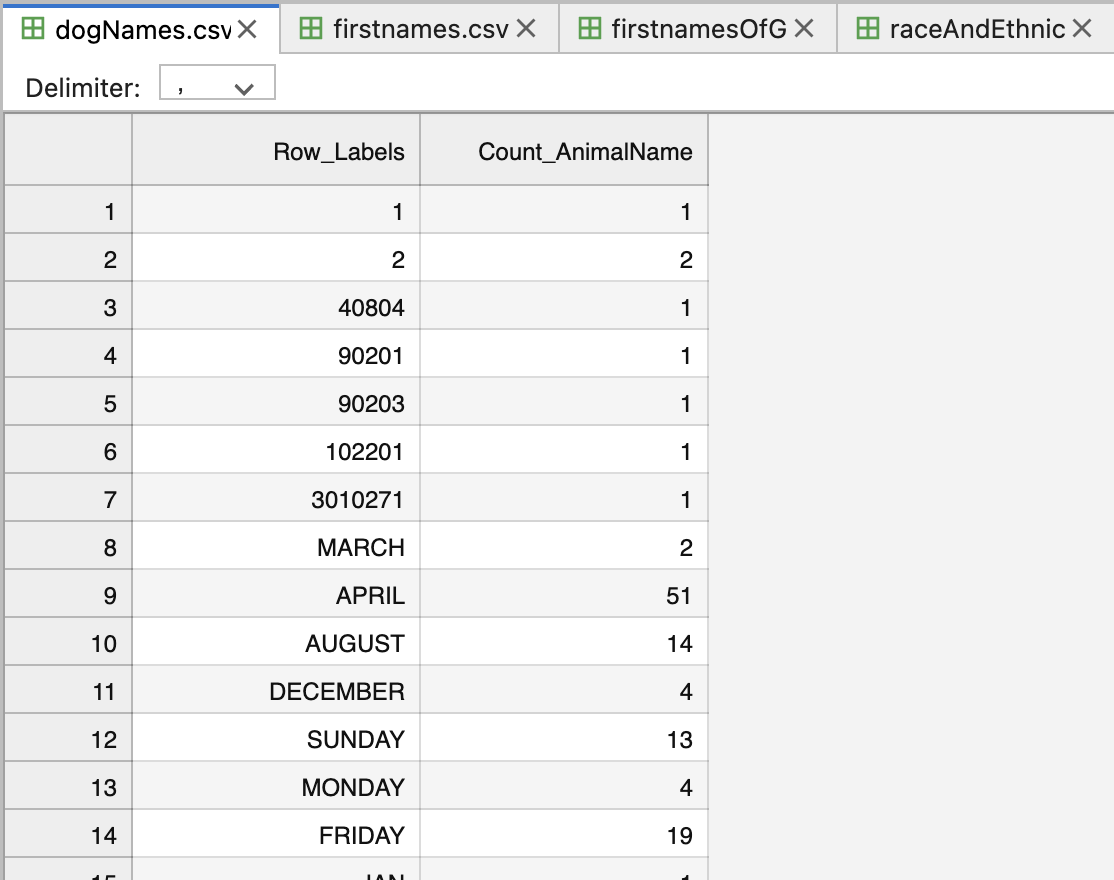
</div>

#### [2] Baby Names Popularity:
https://data.cityofnewyork.us/Health/Popular-Baby-Names/25th-nujf<br> 
Thie data were collected through civil birth registration and found from NYC OpenData. The data represents the ranking of each baby name and can be used to represent the popularity of a name. 
<div>
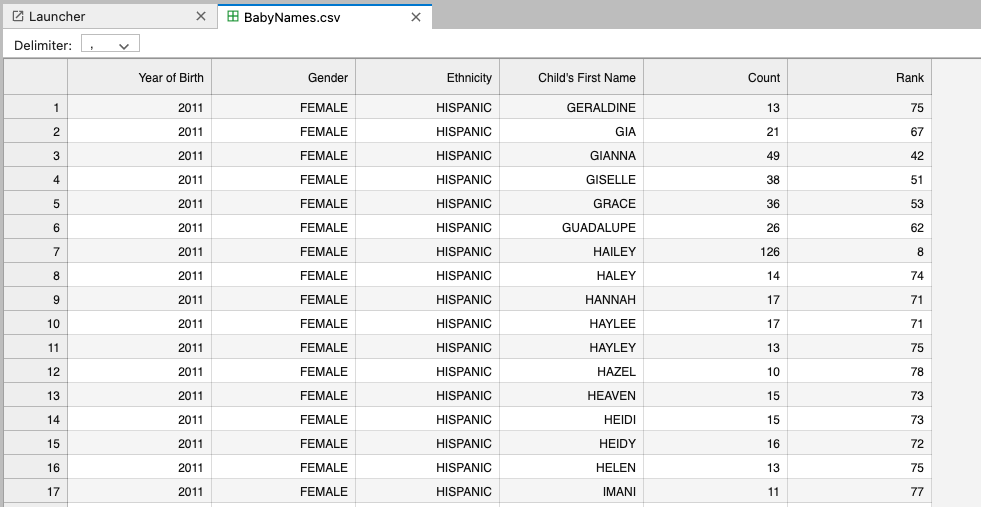
</div>

#### [3] Demographic aspects of first names:
https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/TYJKEZ/MPMHFE&version=1.3<br>
This dataset is provided by Harved dataverse. The data comes with two table with the first name's population and the abbreviation of each poulation column name. This gives us the first name of adult in each population's percentage.
<div>
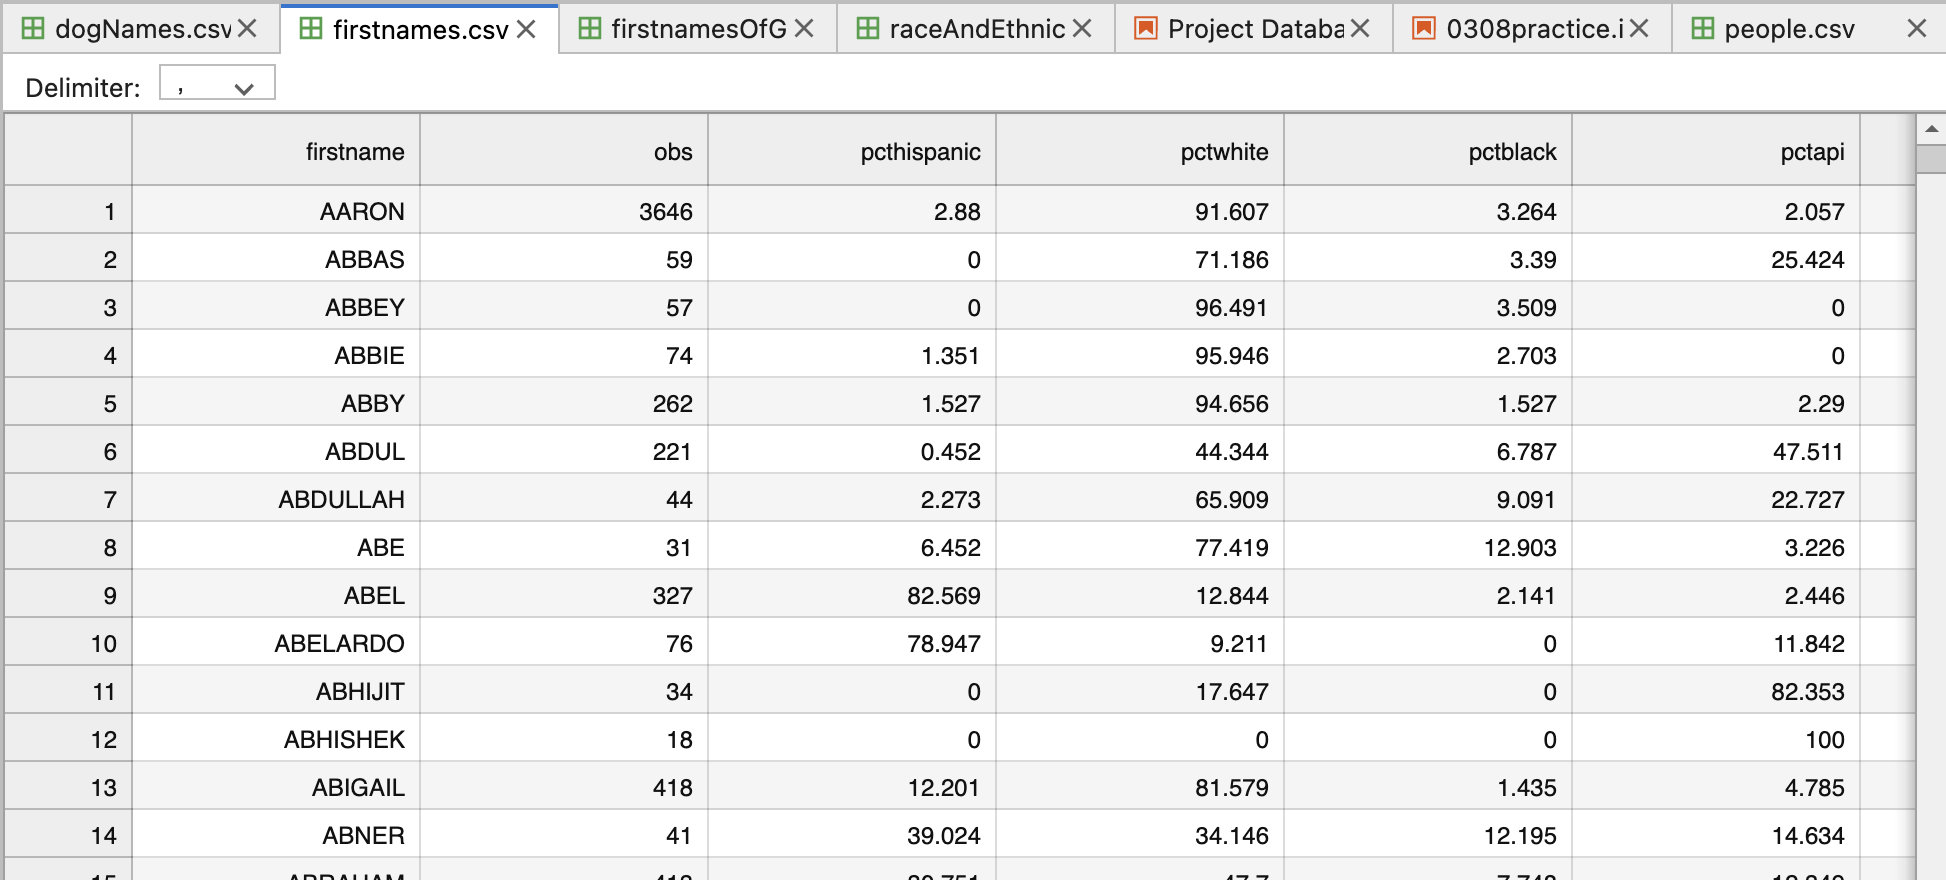
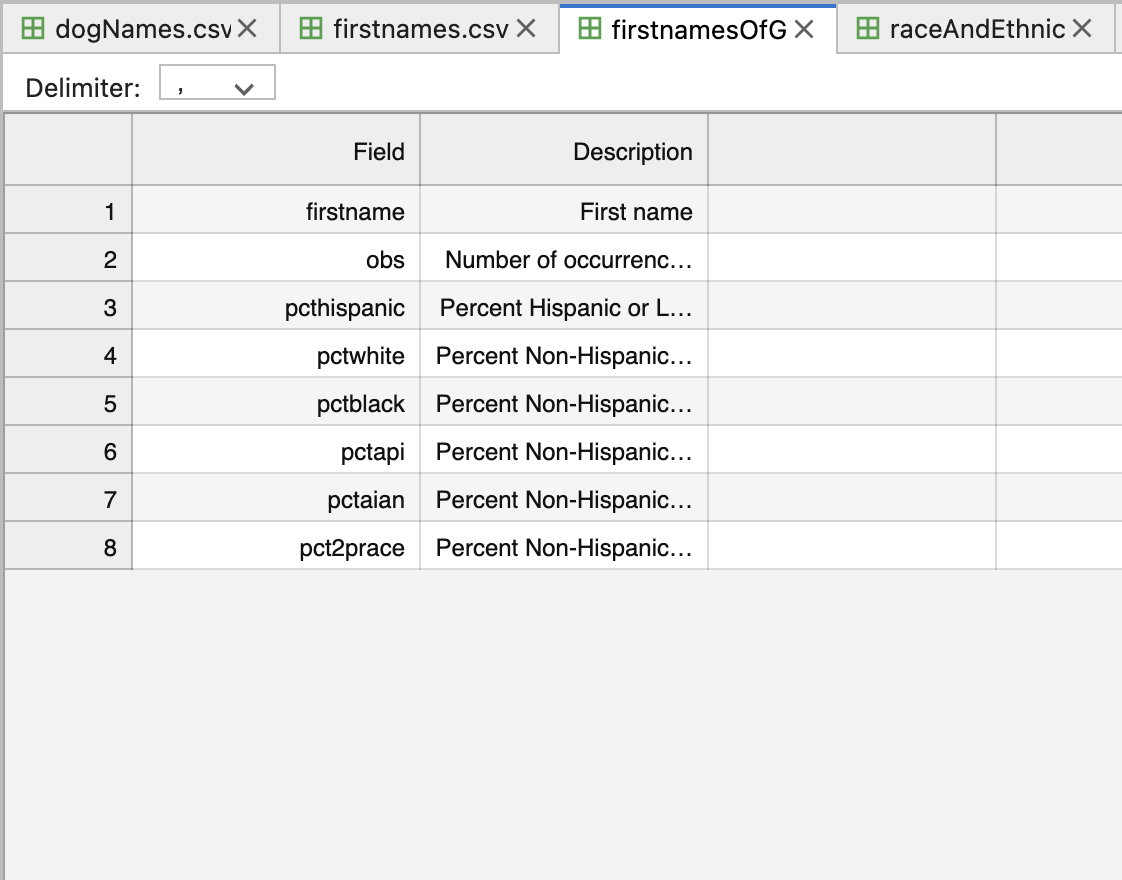
</div>


### Overview of Workflow:


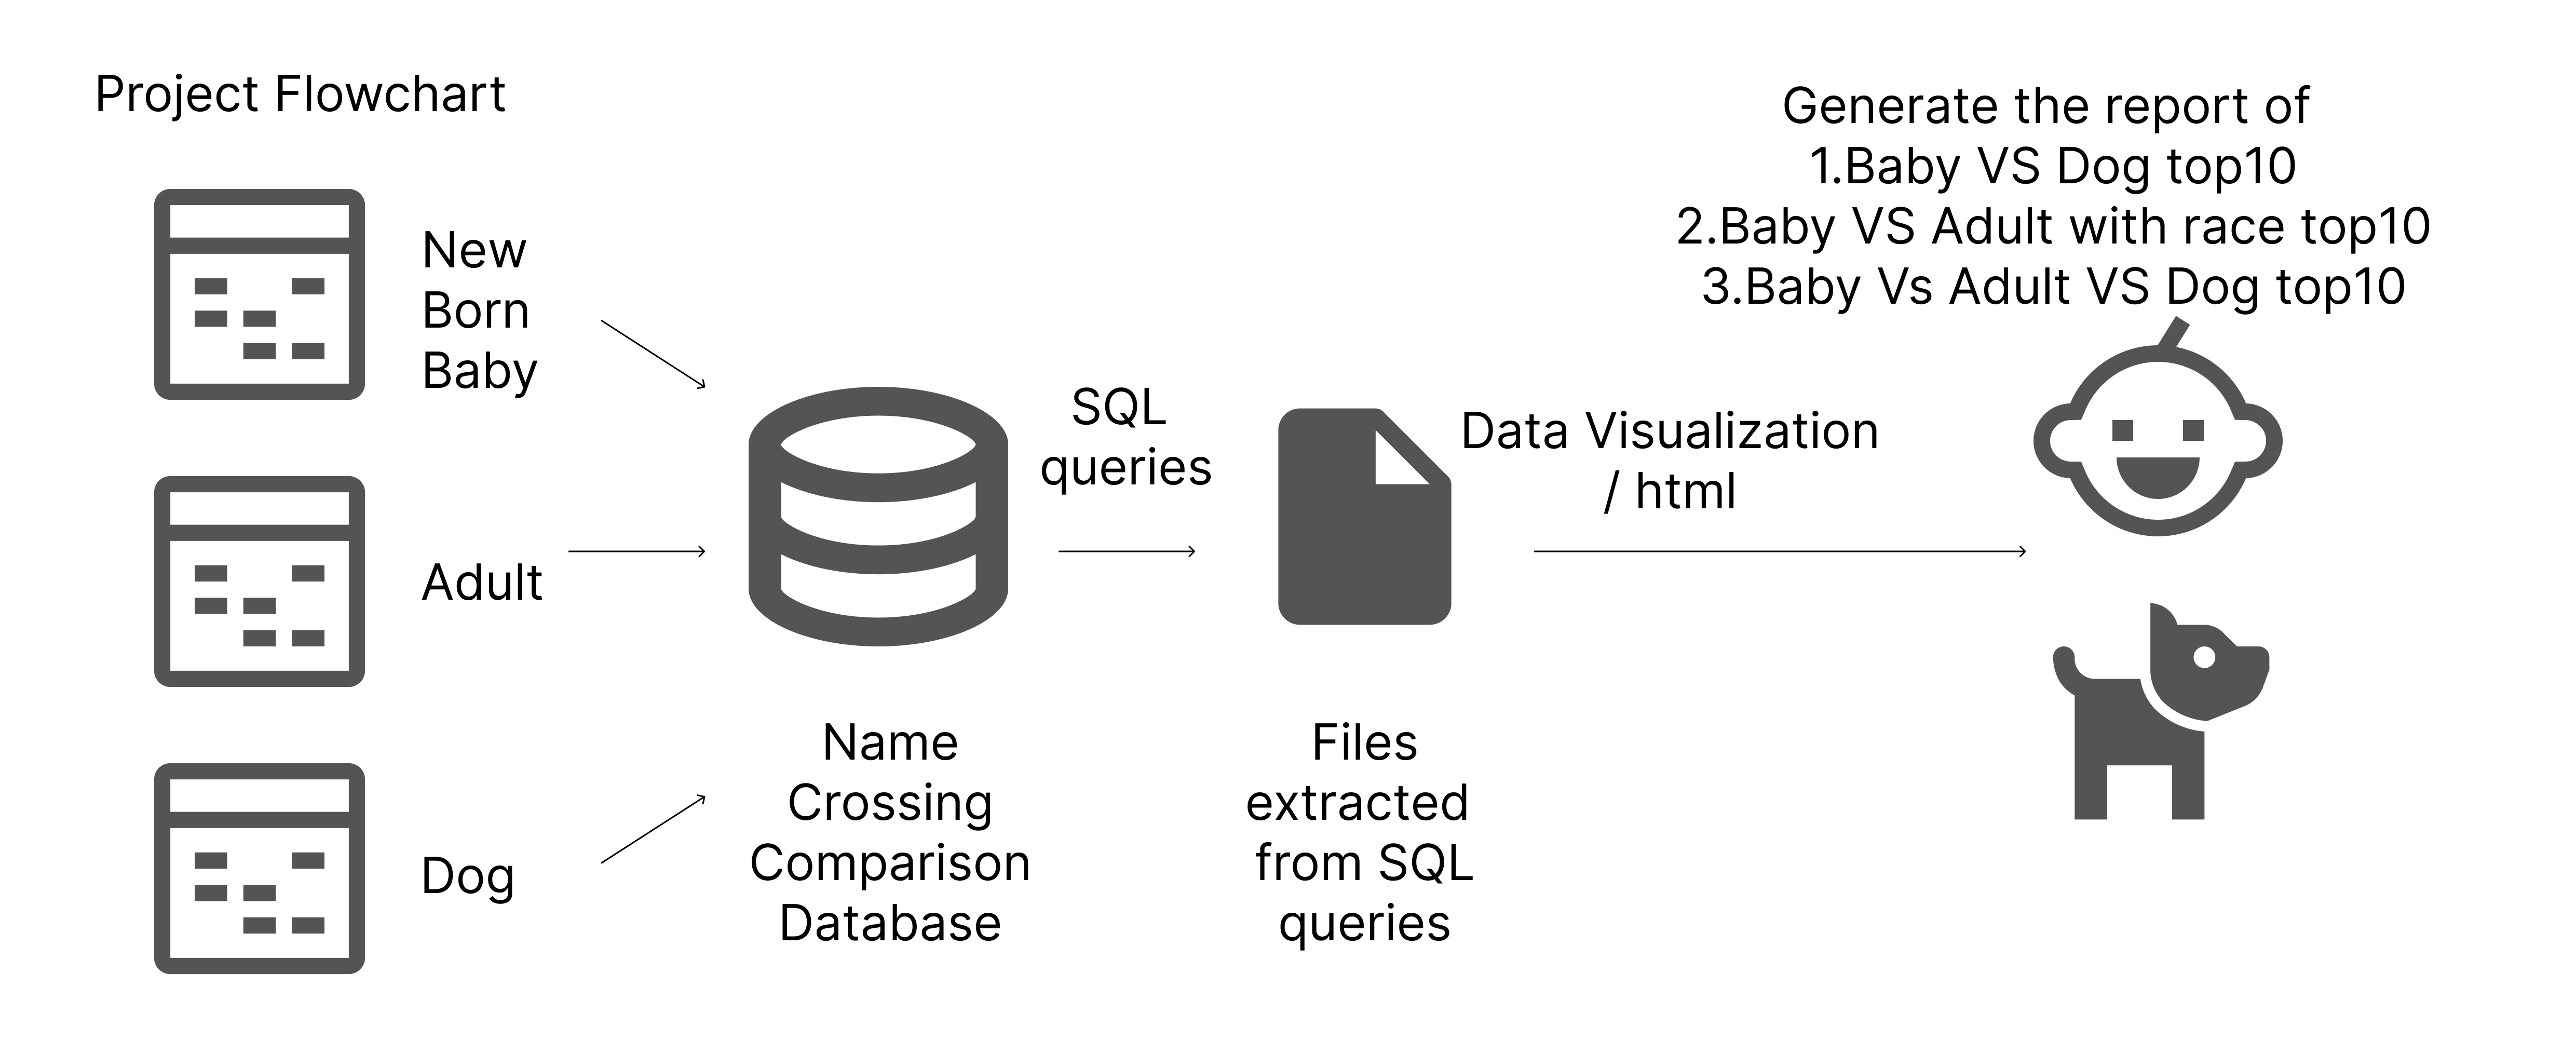

First relationship analyses: 
The BabyNames.csv data sources are based in New York City; they can respectfully demonstrate the naming habit trends. We count and rank the baby names within the project with each year and each race. Then, we use the data source from the Harvard dataset to organize adult names in each race.  In the end, we compare baby names and adult names to check if there are any shared names. 

Second relationship analyses: 
We take the dog name data from Kaggle and receive the popular name ranking by sorting the count. We also make a comparison between dog names and baby names. 

In the end, we also find some interesting relationships and output from comparing the name data. 

### Process:

1. Import all adults, babies and dogs names to the name table. 
2. Import all adults, babies and dogs names with the year, demographic_group_id, gender, name_recipient_group into name_popularity table
3. Create a table for demographic_group_name table to manage synonyms in the names of the demographic group. Therefore, we manually insert value of the canonical name to demo_group table
4. Manually insert value of the alternative name to demo_group_name table (Checked with the csv file that we did not miss any group)
5. Locate and prep the 2019 baby name, 2018 adult and dog name into query
6. Output CSV that contains all the names within the year and name_recipient_group
7. Import CSV to Tableau for visualization and analysis

Notes: The comments within the codes below show more details of how we import the data with the value we want.

### Datebase Design:

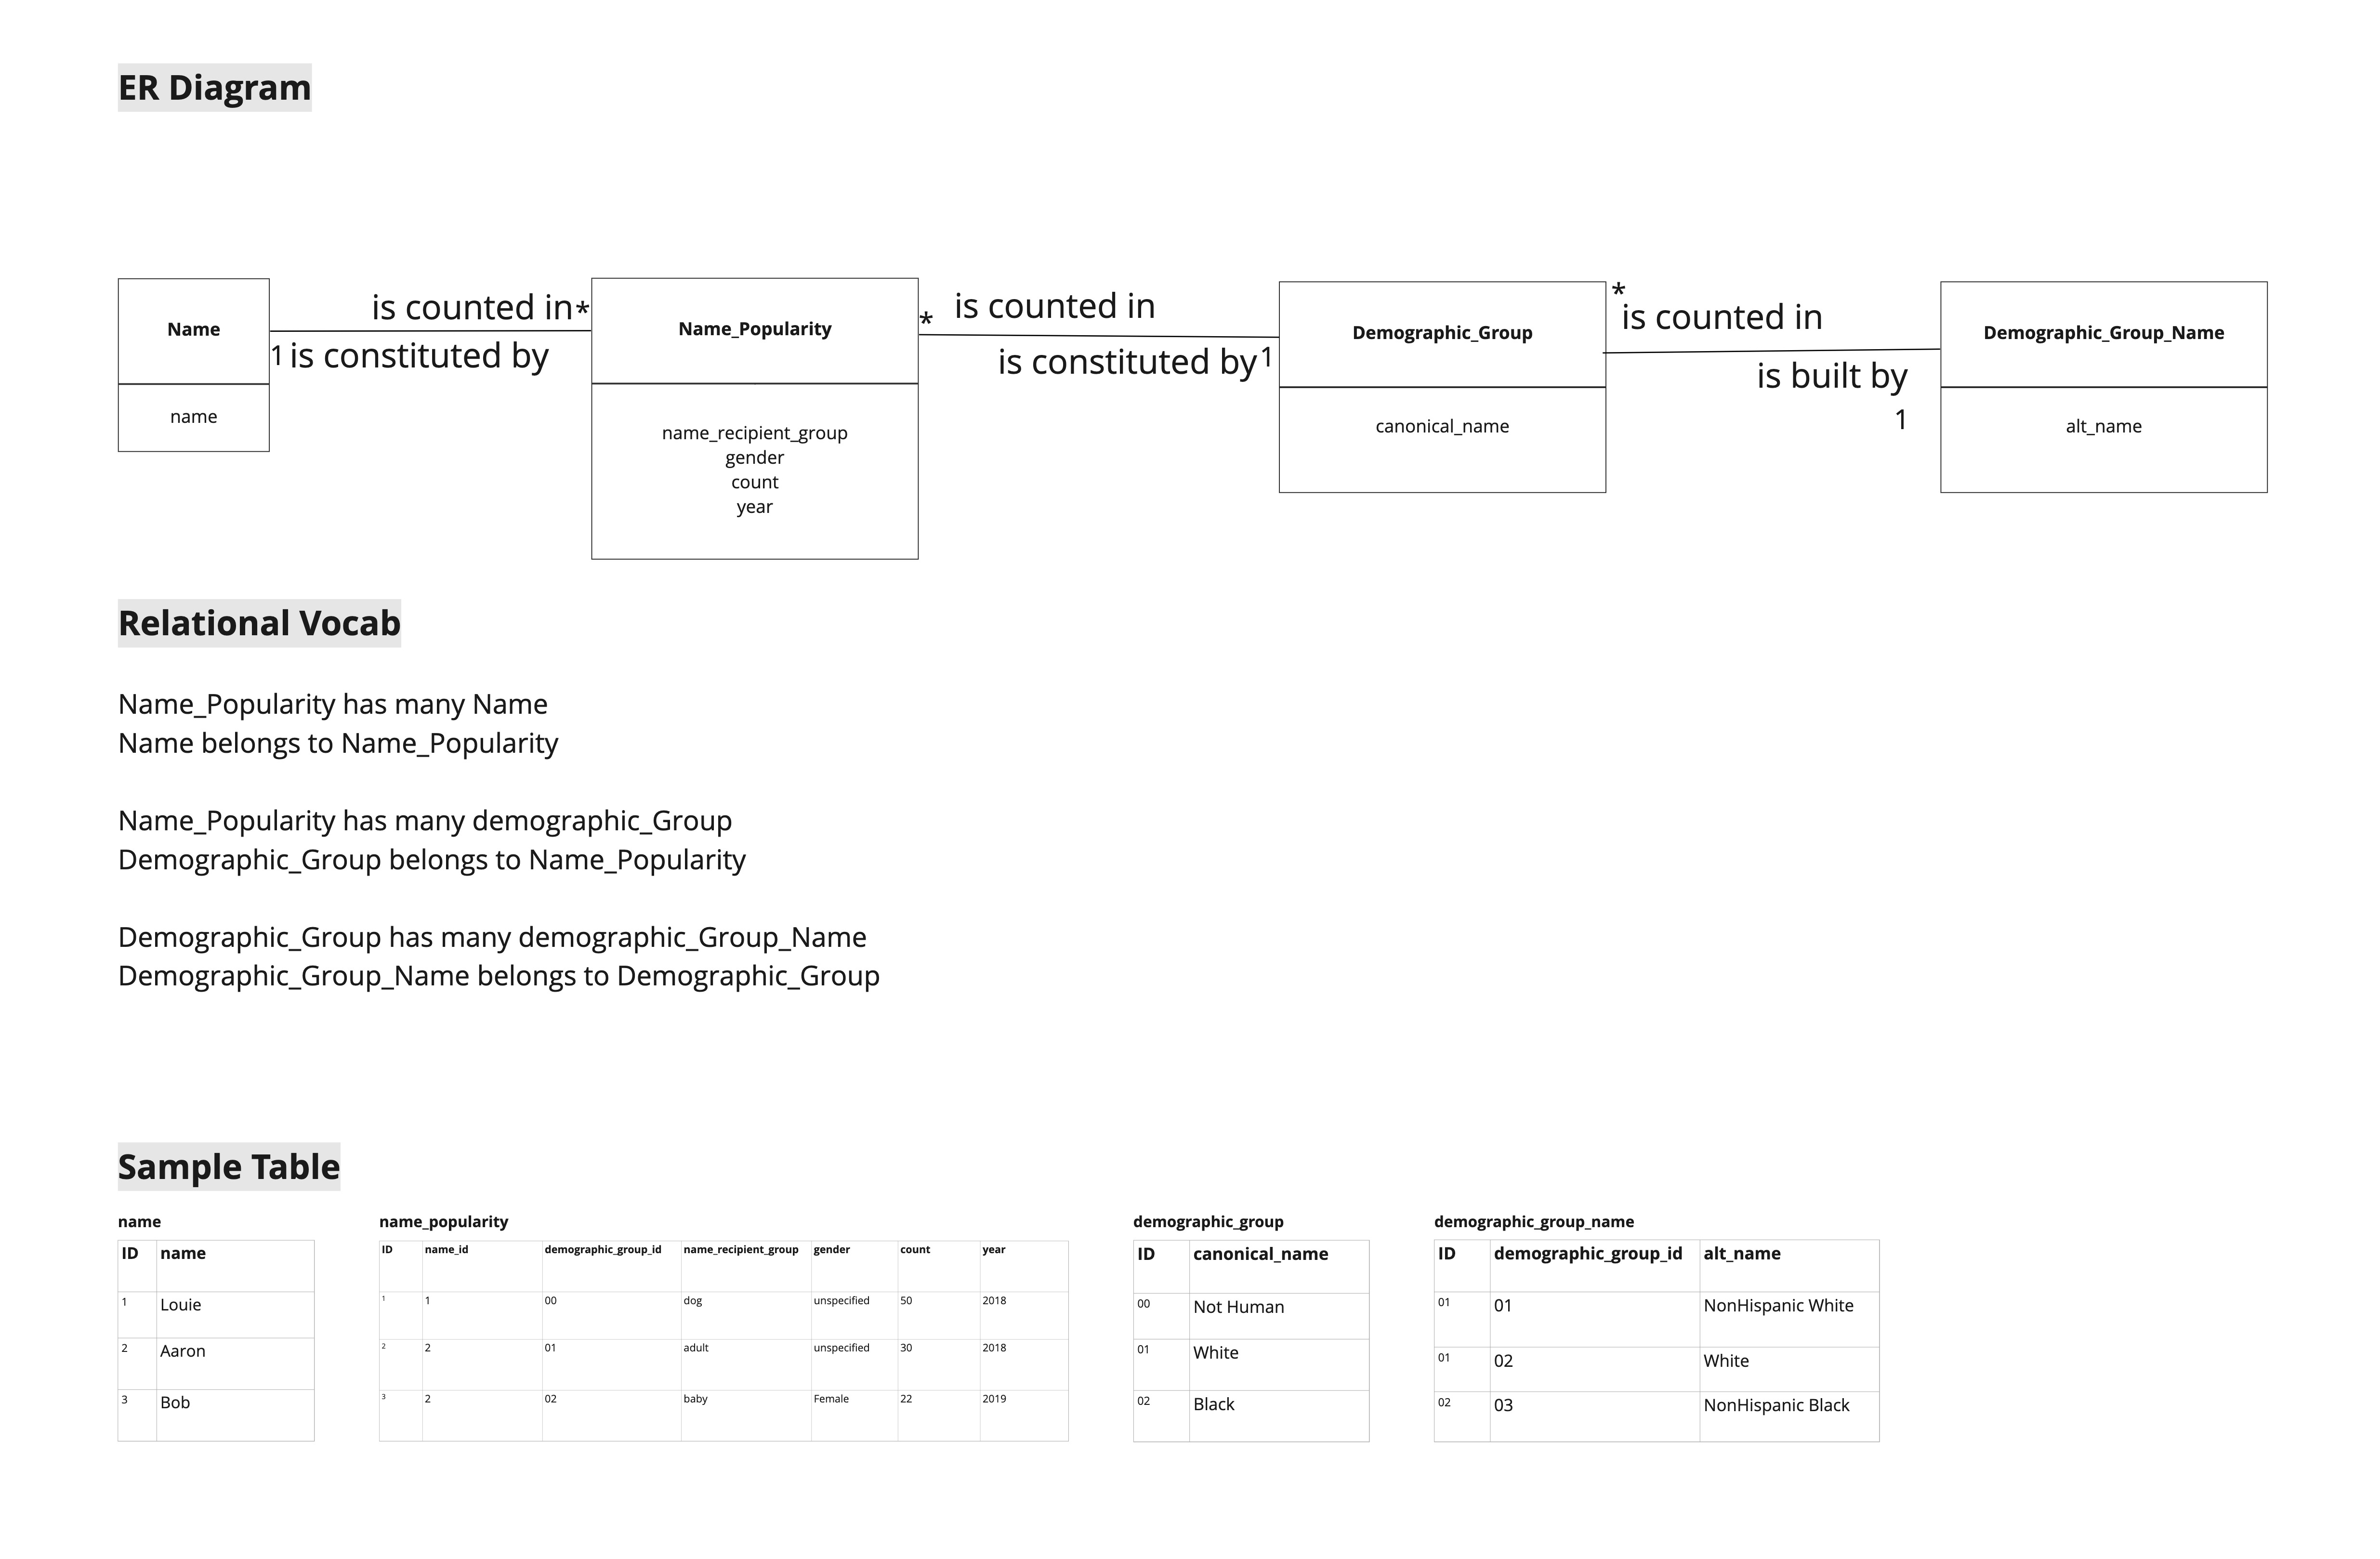

### Dataabse and Tables Setup:

In [1]:
# Open the connection to the database we created called : vp_database1
# Import all the libraries that we need it

import psycopg2
import csv
from psycopg2.extras import RealDictCursor

%load_ext sql
%env DATABASE_URL=postgresql://localhost/vp_database1

env: DATABASE_URL=postgresql://localhost/vp_database1


In [5]:
# Create tables that needed (name_popularity, name, demographic_group, demographic_group_name)

with psycopg2.connect(host='localhost', dbname='vp_database1') as conn:
    with conn.cursor(cursor_factory=RealDictCursor) as cursor:

        cursor.execute(
            """
            DROP TABLE IF EXISTS name_popularity;
            CREATE TABLE name_popularity (
                 id SERIAL PRIMARY KEY,     
                 demographic_group_id INT,
                 name_recipient_group TEXT, -- "baby", "adult" <-- also "dog" if ever add dogs.
                 name_id INT, 
                 gender TEXT, -- unspecified for adults/dogs, male or female for baby names.
                 year INT,
                 count INT
             )
            """
        )
        
        cursor.execute(
            """
            DROP TABLE IF EXISTS name;
            CREATE TABLE name (
                id SERIAL PRIMARY KEY,
                name TEXT
            )
            """
        )
        # use the pattern for synonyms for demographic_group
        cursor.execute(
            """
            DROP TABLE IF EXISTS demographic_group;
            CREATE TABLE demographic_group (
                id INTEGER PRIMARY KEY,
                canonical_name VARCHAR(30) -- "hispanic", "white", "black", "asian"
            )
            """
        )
        
        # manual inserts demographic_group
        cursor.execute(    
            
            """
            INSERT INTO demographic_group (
                id, canonical_name)
            VALUES
                (0, 'Not Human'),
                (1, 'Hispanic'),
                (2, 'White'),
                (3, 'Asian and Pacific Islander'),
                (4, 'Black');
            """
            
        )
        cursor.execute(
            """
            DROP TABLE IF EXISTS demographic_group_name;
            CREATE TABLE demographic_group_name (
                id INTEGER PRIMARY KEY,
                alt_name VARCHAR(30), -- "hispanic", "white", "White Non-Hispanic", "black", "asian", 
                demographic_group_id INTEGER
            )
            """
        )
        
        # manual inserts demographic_group_name (including demographic_group_id)
        cursor.execute(    
            
            """
            INSERT INTO demographic_group_name (
                id, alt_name, demographic_group_id)
            VALUES
                (0, 'unspecified', 0),
                (1, 'HISPANIC', 1),
                (2, 'WHITE NON HISPANIC', 2),
                (3, 'ASIAN AND PACIFIC ISLANDER', 3),
                (4, 'BLACK NON HISPANIC', 4),
                (5, 'ASIAN AND PACI', 3),
                (6, 'BLACK NON HISP', 4),
                (7, 'WHITE NON HISP', 2),
                (8, 'pcthispanic', 1),
                (9, 'pctwhite', 2),
                (10, 'pctaian', 3),
                (11, 'pctblack', 4);
            """
            
        )

### Data Import:

##### Import Baby Names into name table

In [6]:
with psycopg2.connect(host='localhost', dbname='vp_database1') as conn:
    with conn.cursor(cursor_factory=RealDictCursor) as cursor:
        cursor.execute("TRUNCATE name;") #Clear the table before inserting all the data
        
        with open('BabyNames.csv') as csvfile:
          # tell python about the specific csv format
          myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')

          # move row by row through the file
          for row in myCSVReader:
                
                row['Childs_First_Name'] = row['Childs_First_Name'].lower() # using the context from column 'Childs_First_Name' from BabyNames.csv
                cursor.execute("SELECT id FROM name WHERE name = %(Childs_First_Name)s", 
                               row)
                
                if (cursor.rowcount == 1):
                    name_id = cursor.fetchone()['id']
                else:
                    cursor.execute("""
                                    INSERT INTO name(name)
                                    VALUES (
                                         %(Childs_First_Name)s
                                    ) 
                                    RETURNING id
                                    """,
                                    row)  
                    # store the id for the new name
                    name_id = cursor.fetchone()['id']
print("Done")

Done


##### Import Adult Names into name table

In [10]:
with psycopg2.connect(host='localhost', dbname='vp_database1') as conn:
    with conn.cursor(cursor_factory=RealDictCursor) as cursor:

        with open('FirstNames.csv') as csvfile:
          # tell python about the specific csv format
          myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
          
          for row in myCSVReader:
                
                row['firstname'] = row['firstname'].lower() # using the context from column 'firstname' from FirstNames.csv
                cursor.execute("SELECT id FROM name WHERE name = %(firstname)s", 
                               row)

                if (cursor.rowcount == 1):
                    name_id = cursor.fetchone()['id']
                else:
                    cursor.execute("""
                                    INSERT INTO name(name)
                                    VALUES (
                                         %(firstname)s
                                    ) 
                                    RETURNING id
                                    """,
                                    row)  
                    # store the id for the new name
                    name_id = cursor.fetchone()['id']
print("Done")

Done


##### Import Dog Names into name table

In [11]:
with psycopg2.connect(host='localhost', dbname='vp_database1') as conn:
    with conn.cursor(cursor_factory=RealDictCursor) as cursor:

        with open('DogNames.csv') as csvfile:
          # tell python about the specific csv format
          myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')

          for row in myCSVReader:
                
                row['Row_Labels'] = row['Row_Labels'].lower() # using the context from column 'Row_Labels' from DogNames.csv
                cursor.execute("SELECT id FROM name WHERE name = %(Row_Labels)s", 
                               row)

                if (cursor.rowcount == 1):
                    name_id = cursor.fetchone()['id']
                else:
                    cursor.execute("""
                                    INSERT INTO name(name)
                                    VALUES (
                                         %(Row_Labels)s
                                    ) 
                                    RETURNING id
                                    """,
                                    row)  
                    # store the id for the new name
                    name_id = cursor.fetchone()['id']
print("Done")

Done


##### Put all other attributes(year, demographic_group_id, gender, name_recipient_group) of Baby names into name_popularity table

In [13]:
sql_select_name = "SELECT id from name WHERE name = %(Childs_First_Name)s" # select the id from names 
sql_select_demographic_group = "SELECT demographic_group_id from demographic_group_name WHERE alt_name = %(Ethnicity)s" # select the demo_id from demo_group to match the alt_name


with psycopg2.connect(host='localhost', dbname='vp_database1') as conn:
    with conn.cursor(cursor_factory=RealDictCursor) as cursor:
        
        with open('BabyNames.csv') as csvfile:
            myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')

            
            for row in myCSVReader:
                
                cursor.execute(sql_select_demographic_group, row) # use the demo_group name from the row to get the demo_id
                demographic_group_id = cursor.fetchone()['demographic_group_id']
                
                row['Childs_First_Name'] = row['Childs_First_Name'].lower() # convert all the name to lowercase, avoid the same name with different format
                cursor.execute(sql_select_name, row) # use the name from the row to get the name_id
                name_id = cursor.fetchone()['id']
                
                
                param_dict = {'name_recipient_group': "baby", # define to baby, true for whole file
                            'demographic_group_id': demographic_group_id,
                             'name_id' : name_id, # look up an name id
                             'count' : row['Count'],
                             'gender' : row['Gender'],
                             'year': row['Year_of_Birth']} 
                
                # because of the data source was not organized
                # use a SELECT query to see if this row is already inserted, if yes, we will add the count 
                cursor.execute("""
                        SELECT *
                        FROM name_popularity
                        WHERE demographic_group_id = %(demographic_group_id)s
                          AND name_recipient_group = %(name_recipient_group)s
                          AND name_id  = %(name_id)s
                          AND gender = %(gender)s
                          AND year = %(year)s
                    """,
                    param_dict)
                    
                if (cursor.rowcount == 0):
                    cursor.execute("""
                          INSERT INTO name_popularity(
                                    demographic_group_id,
                                    name_recipient_group,
                                    name_id,
                                    gender,
                                    year,
                                    count
                                ) VALUES (
                                    %(demographic_group_id)s,
                                    %(name_recipient_group)s,
                                    %(name_id)s,
                                    %(gender)s,
                                    %(year)s,
                                    %(count)s
                                )
                                """,
                                   param_dict
                        )
                else:
                    cursor.execute("""
                            UPDATE name_popularity
                            SET count = count + %(count)s
                            WHERE demographic_group_id = %(demographic_group_id)s
                              AND name_recipient_group = %(name_recipient_group)s
                              AND name_id  = %(name_id)s
                              AND gender = %(gender)s
                              AND year = %(year)s
                              """,
                            param_dict
                        )
                    
                    
                
print("Done loading")

Done loading


##### Put all other attributes(year, demographic_group_id, gender, name_recipient_group) of Adult names into name_popularity table

In [14]:
sql_select_name = "SELECT id from name WHERE name = %(firstname)s" # select id from names


with psycopg2.connect(host='localhost', dbname='vp_database1') as conn:
    with conn.cursor(cursor_factory=RealDictCursor) as cursor:
        
        with open('FirstNames.csv') as csvfile:
            myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')

            
            for row in myCSVReader:
                row['firstname'] = row['firstname'].lower() # convert all the name to lowercase, avoid the same name with different format
                cursor.execute(sql_select_name, row) # use the name from the row to get the name_id
                name_id = cursor.fetchone()['id']
                
                total_adult_count = int(row['obs']) # 'obs' is the total count for names that includes all the demographic group
                
                for column in ["pcthispanic", "pctwhite","pctblack","pctaian"]:
                    
                    #
                    lookup_sql = """
                        SELECT demographic_group_id
                        FROM demographic_group_name
                        WHERE alt_name = %(column)s
                        """
                    param_dict = {'column': column} # FirstNames.csv has each race's population listed it by using seperated column, not inside the row
                    cursor.execute(lookup_sql, param_dict) # use the demo_group from the row to get the demo_id
                    demographic_group_id = cursor.fetchone()['demographic_group_id']
                    
                    param_dict = {'name_id': name_id,
                                 'gender': "unspecified", # true for whole file because the data source does not provide this value
                                 'demographic_group_id': demographic_group_id,
                                 'name_recipient_group': "adult", # true for whole file
                                 'year': "2018"}
                    
                    pct_group = float(row[column]) # need the percentage of names in each group
                   
                    # calculate the count for the group 
                    # need the count of names in each group, we multipy the pct by the observations
                    param_dict['count'] = round(pct_group * total_adult_count) # round up all the number because people can't be decimal
                    
                    
                    # because of the data source was not organized
                    # use a SELECT query to see if this row is already inserted, if yes, we will add and sum the count 
                    cursor.execute("""
                        SELECT *
                        FROM name_popularity
                        WHERE demographic_group_id = %(demographic_group_id)s
                          AND name_recipient_group = %(name_recipient_group)s
                          AND name_id  = %(name_id)s
                          AND gender = %(gender)s
                          AND year = %(year)s
                    """,
                    param_dict)
                    
                    if (cursor.rowcount == 0):
                        cursor.execute("""
                          INSERT INTO name_popularity(
                                    demographic_group_id,
                                    name_recipient_group,
                                    name_id,
                                    gender,
                                    year,
                                    count
                                ) VALUES (
                                    %(demographic_group_id)s,
                                    %(name_recipient_group)s,
                                    %(name_id)s,
                                    %(gender)s,
                                    %(year)s,
                                    %(count)s
                                )
                                """,
                                   param_dict
                        )
                    else:
                        cursor.execute("""
                            UPDATE name_popularity
                            SET count = count + %(count)s
                            WHERE demographic_group_id = %(demographic_group_id)s
                              AND name_recipient_group = %(name_recipient_group)s
                              AND name_id  = %(name_id)s
                              AND gender = %(gender)s
                              AND year = %(year)s
                              """,
                            param_dict
                        )
                    
print("Done loading")

Done loading


##### Put all other attributes(year, demographic_group_id, gender, name_recipient_group) of Dog names into name_popularity table

In [15]:
sql_select_name = "SELECT id from name WHERE name = %(Row_Labels)s" # select id from names

with psycopg2.connect(host='localhost', dbname='vp_database1') as conn:
    with conn.cursor(cursor_factory=RealDictCursor) as cursor:
        
        with open('DogNames.csv') as csvfile:
            myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
            
            for row in myCSVReader:
                
                row['Row_Labels'] = row['Row_Labels'].lower() # convert all the name to lowercase, avoid the same name with different format
                cursor.execute(sql_select_name, row) # use the name from the row to get the name_id
                name_id = cursor.fetchone()['id']
                
                
                param_dict = {'name_recipient_group': "dog", # true for whole file
                             'demographic_group_id': 0,  # true for whole file, not Human
                             'name_id' : name_id,
                             'count' : row['Count_AnimalName'],
                             'gender' : "unspecified", # true for whole file
                             'year': "2018"} # true for whole file because the data only provides year of 2018
        
        
                # because of the data source was not organized
                # use a SELECT query to see if this row is already inserted, if yes, we will add and sum the count 
                cursor.execute("""
                        SELECT *
                        FROM name_popularity
                        WHERE demographic_group_id = %(demographic_group_id)s
                          AND name_recipient_group = %(name_recipient_group)s
                          AND name_id  = %(name_id)s
                          AND gender = %(gender)s
                          AND year = %(year)s
                    """,
                    param_dict)
                    
                if (cursor.rowcount == 0):
                    cursor.execute("""
                          INSERT INTO name_popularity(
                                    demographic_group_id,
                                    name_recipient_group,
                                    name_id,
                                    gender,
                                    year,
                                    count
                                ) VALUES (
                                    %(demographic_group_id)s,
                                    %(name_recipient_group)s,
                                    %(name_id)s,
                                    %(gender)s,
                                    %(year)s,
                                    %(count)s
                                )
                                """,
                                   param_dict
                        )
                else:
                    cursor.execute("""
                            UPDATE name_popularity
                            SET count = count + %(count)s
                            WHERE demographic_group_id = %(demographic_group_id)s
                              AND name_recipient_group = %(name_recipient_group)s
                              AND name_id  = %(name_id)s
                              AND gender = %(gender)s
                              AND year = %(year)s
                              """,
                            param_dict
                        )
                    
                
print("Done loading")

Done loading


### Queries Testing:

In [35]:
%%sql

SELECT name_popularity.id, year, name_recipient_group, count
FROM name_popularity 
JOIN demographic_group
  ON demographic_group_id = name_popularity.demographic_group_id  
JOIN name
  ON name.id = name_popularity.name_id
GROUP BY name_popularity.id
ORDER BY name_popularity.count desc
LIMIT 10

-- In this query, we receive the top 10 popular name_id from baby, adult and dog based on the count, not the rank 
-- They are all adult names because the adult names has the largest number from the data
-- We do not need to join demographic_group_name because we already have demographic_group_id that can represent the demo group

 * postgresql://localhost/vp_database1
10 rows affected.


id,year,name_recipient_group,count
33090,2018,adult,11010684
27218,2018,adult,5617618
23826,2018,adult,4879275
29398,2018,adult,4561101
19790,2018,adult,4483276
23186,2018,adult,4298600
32630,2018,adult,3018592
29298,2018,adult,2720305
31590,2018,adult,2628893
33091,2018,adult,2471205


In [11]:
%%sql

SELECT name_popularity.year, name_popularity.name_recipient_group, demographic_group.canonical_name AS demo_group, name.name AS name, count
FROM name_popularity 
JOIN name
    ON name.id = name_popularity.name_id
JOIN demographic_group
    ON demographic_group.id = name_popularity.demographic_group_id
WHERE name_popularity.name_recipient_group = 'baby' and name_popularity.demographic_group_id = 1
ORDER BY count DESC, name_popularity.year, name_popularity.name_recipient_group, demographic_group.canonical_name, name.name
LIMIT 10

-- In this query, we set the sorting by having "hispanic" demographic group from babies and order by the count
-- Therefore, we receive 10 most popular Hispanic baby name from all the years 

 * postgresql://localhost/vp_database1
10 rows affected.


year,name_recipient_group,demo_group,name,count
2011,baby,Hispanic,isabella,1324
2011,baby,Hispanic,jayden,1278
2014,baby,Hispanic,liam,1248
2011,baby,Hispanic,justin,1240
2011,baby,Hispanic,jacob,1212
2012,baby,Hispanic,jacob,1172
2014,baby,Hispanic,dylan,1168
2012,baby,Hispanic,matthew,1116
2011,baby,Hispanic,matthew,1104
2012,baby,Hispanic,jayden,1092


In [21]:
%%sql 

SELECT *
FROM (
    SELECT  name_popularity.year,
            name_popularity.name_recipient_group,
            demographic_group.canonical_name AS demographic_group,
            name.name AS name,
            name_popularity.gender,
            count,
            DENSE_RANK () OVER (                                  
                PARTITION BY year, 
                             name_recipient_group, 
                             demographic_group.canonical_name,
                             name_popularity.gender
                ORDER BY count desc
            ) AS name_rank  

    FROM name_popularity 
    JOIN name
        ON name.id = name_popularity.name_id
    JOIN demographic_group
        ON demographic_group.id = name_popularity.demographic_group_id
    
) AS name_rankings
WHERE name_rank > 1 and (name_rank <= 2) and (year = 2019 or year = 2018)


-- Used sub query to used as a new relation on the outer query to applied the ranking option
-- In this setting, we receive second popular name from each demographic group and name_recipient_group by using the rank based on each population amount

 * postgresql://localhost/vp_database1
14 rows affected.


year,name_recipient_group,demographic_group,name,gender,count,name_rank
2018,adult,Asian and Pacific Islander,john,unspecified,6410,2
2018,adult,Black,james,unspecified,149922,2
2018,adult,Hispanic,jose,unspecified,776302,2
2018,adult,White,michael,unspecified,5617618,2
2018,dog,Not Human,max,unspecified,1153,2
2019,baby,Asian and Pacific Islander,olivia,FEMALE,109,2
2019,baby,Asian and Pacific Islander,lucas,MALE,153,2
2019,baby,Black,madison,FEMALE,59,2
2019,baby,Black,amir,MALE,101,2
2019,baby,Hispanic,emma,FEMALE,213,2


### Data Export:

The new query we used for exporting is:

`SELECT *
                FROM (
                    SELECT  name_popularity.year,
                            name_popularity.name_recipient_group,
                            demographic_group.canonical_name AS demographic_group,
                            name.name AS name,
                            name_popularity.gender,
                            count,
                            DENSE_RANK () OVER (                                  
                                PARTITION BY year, 
                                             name_recipient_group, 
                                             demographic_group.canonical_name,
                                             name_popularity.gender
                                ORDER BY count desc
                            ) AS name_rank  

                    FROM name_popularity 
                    JOIN name
                        ON name.id = name_popularity.name_id
                    JOIN demographic_group
                        ON demographic_group.id = name_popularity.demographic_group_id

                ) AS name_rankings
                WHERE name_rank <= 30 and (year = 2019 or year = 2018)
`

We want to analyze the name trend with a single year.
`WHERE name_rank <= 30 and (year = 2019 or year = 2018)` is because the data of adult and dog only contain year of 2018; however, baby names does not include year of 2018 but 2019. Therefore, we put year of 2018 for dog and adult, and year of 2019 of baby together to analyze the intersection(if they named the same name). 

In [ ]:
with psycopg2.connect(host='localhost', dbname='vp_database1') as conn:
    with conn.cursor(cursor_factory=RealDictCursor) as cur:

        cur.execute(
            """
             SELECT *
                FROM (
                    SELECT  name_popularity.year,
                            name_popularity.name_recipient_group,
                            demographic_group.canonical_name AS demographic_group,
                            name.name AS name,
                            name_popularity.gender,
                            count,
                            DENSE_RANK () OVER (                                  
                                PARTITION BY year, 
                                             name_recipient_group, 
                                             demographic_group.canonical_name,
                                             name_popularity.gender
                                ORDER BY count desc
                            ) AS name_rank  

                    FROM name_popularity 
                    JOIN name
                        ON name.id = name_popularity.name_id
                    JOIN demographic_group
                        ON demographic_group.id = name_popularity.demographic_group_id

                ) AS name_rankings
                WHERE name_rank <= 30 and (year = 2019 or year = 2018)

            """)

        with open('data_export.csv', 'w', newline='') as csvfile:
                    # Declare csv fields in the order we want them
            column_names = ["year", "name_recipient_group", "demographic_group", "name", "gender", "count", "name_rank"]
            myCsvWriter = csv.DictWriter(csvfile,
                                                 delimiter = ',',
                                                fieldnames = column_names)

            myCsvWriter.writeheader()

            for row in cur:          
                myCsvWriter.writerow(row)

print("Done writing csv")

### Analyze Result:

To visualize the results for our analysis, we decide to use Tableau to present out final result of naming trend.  


#### Below shows the top 10 popular name from Adult and Baby
Each rank of Baby has 2 names to represent female and male. From this bar chart, we can know that there's no same name from each group who has the same rank.
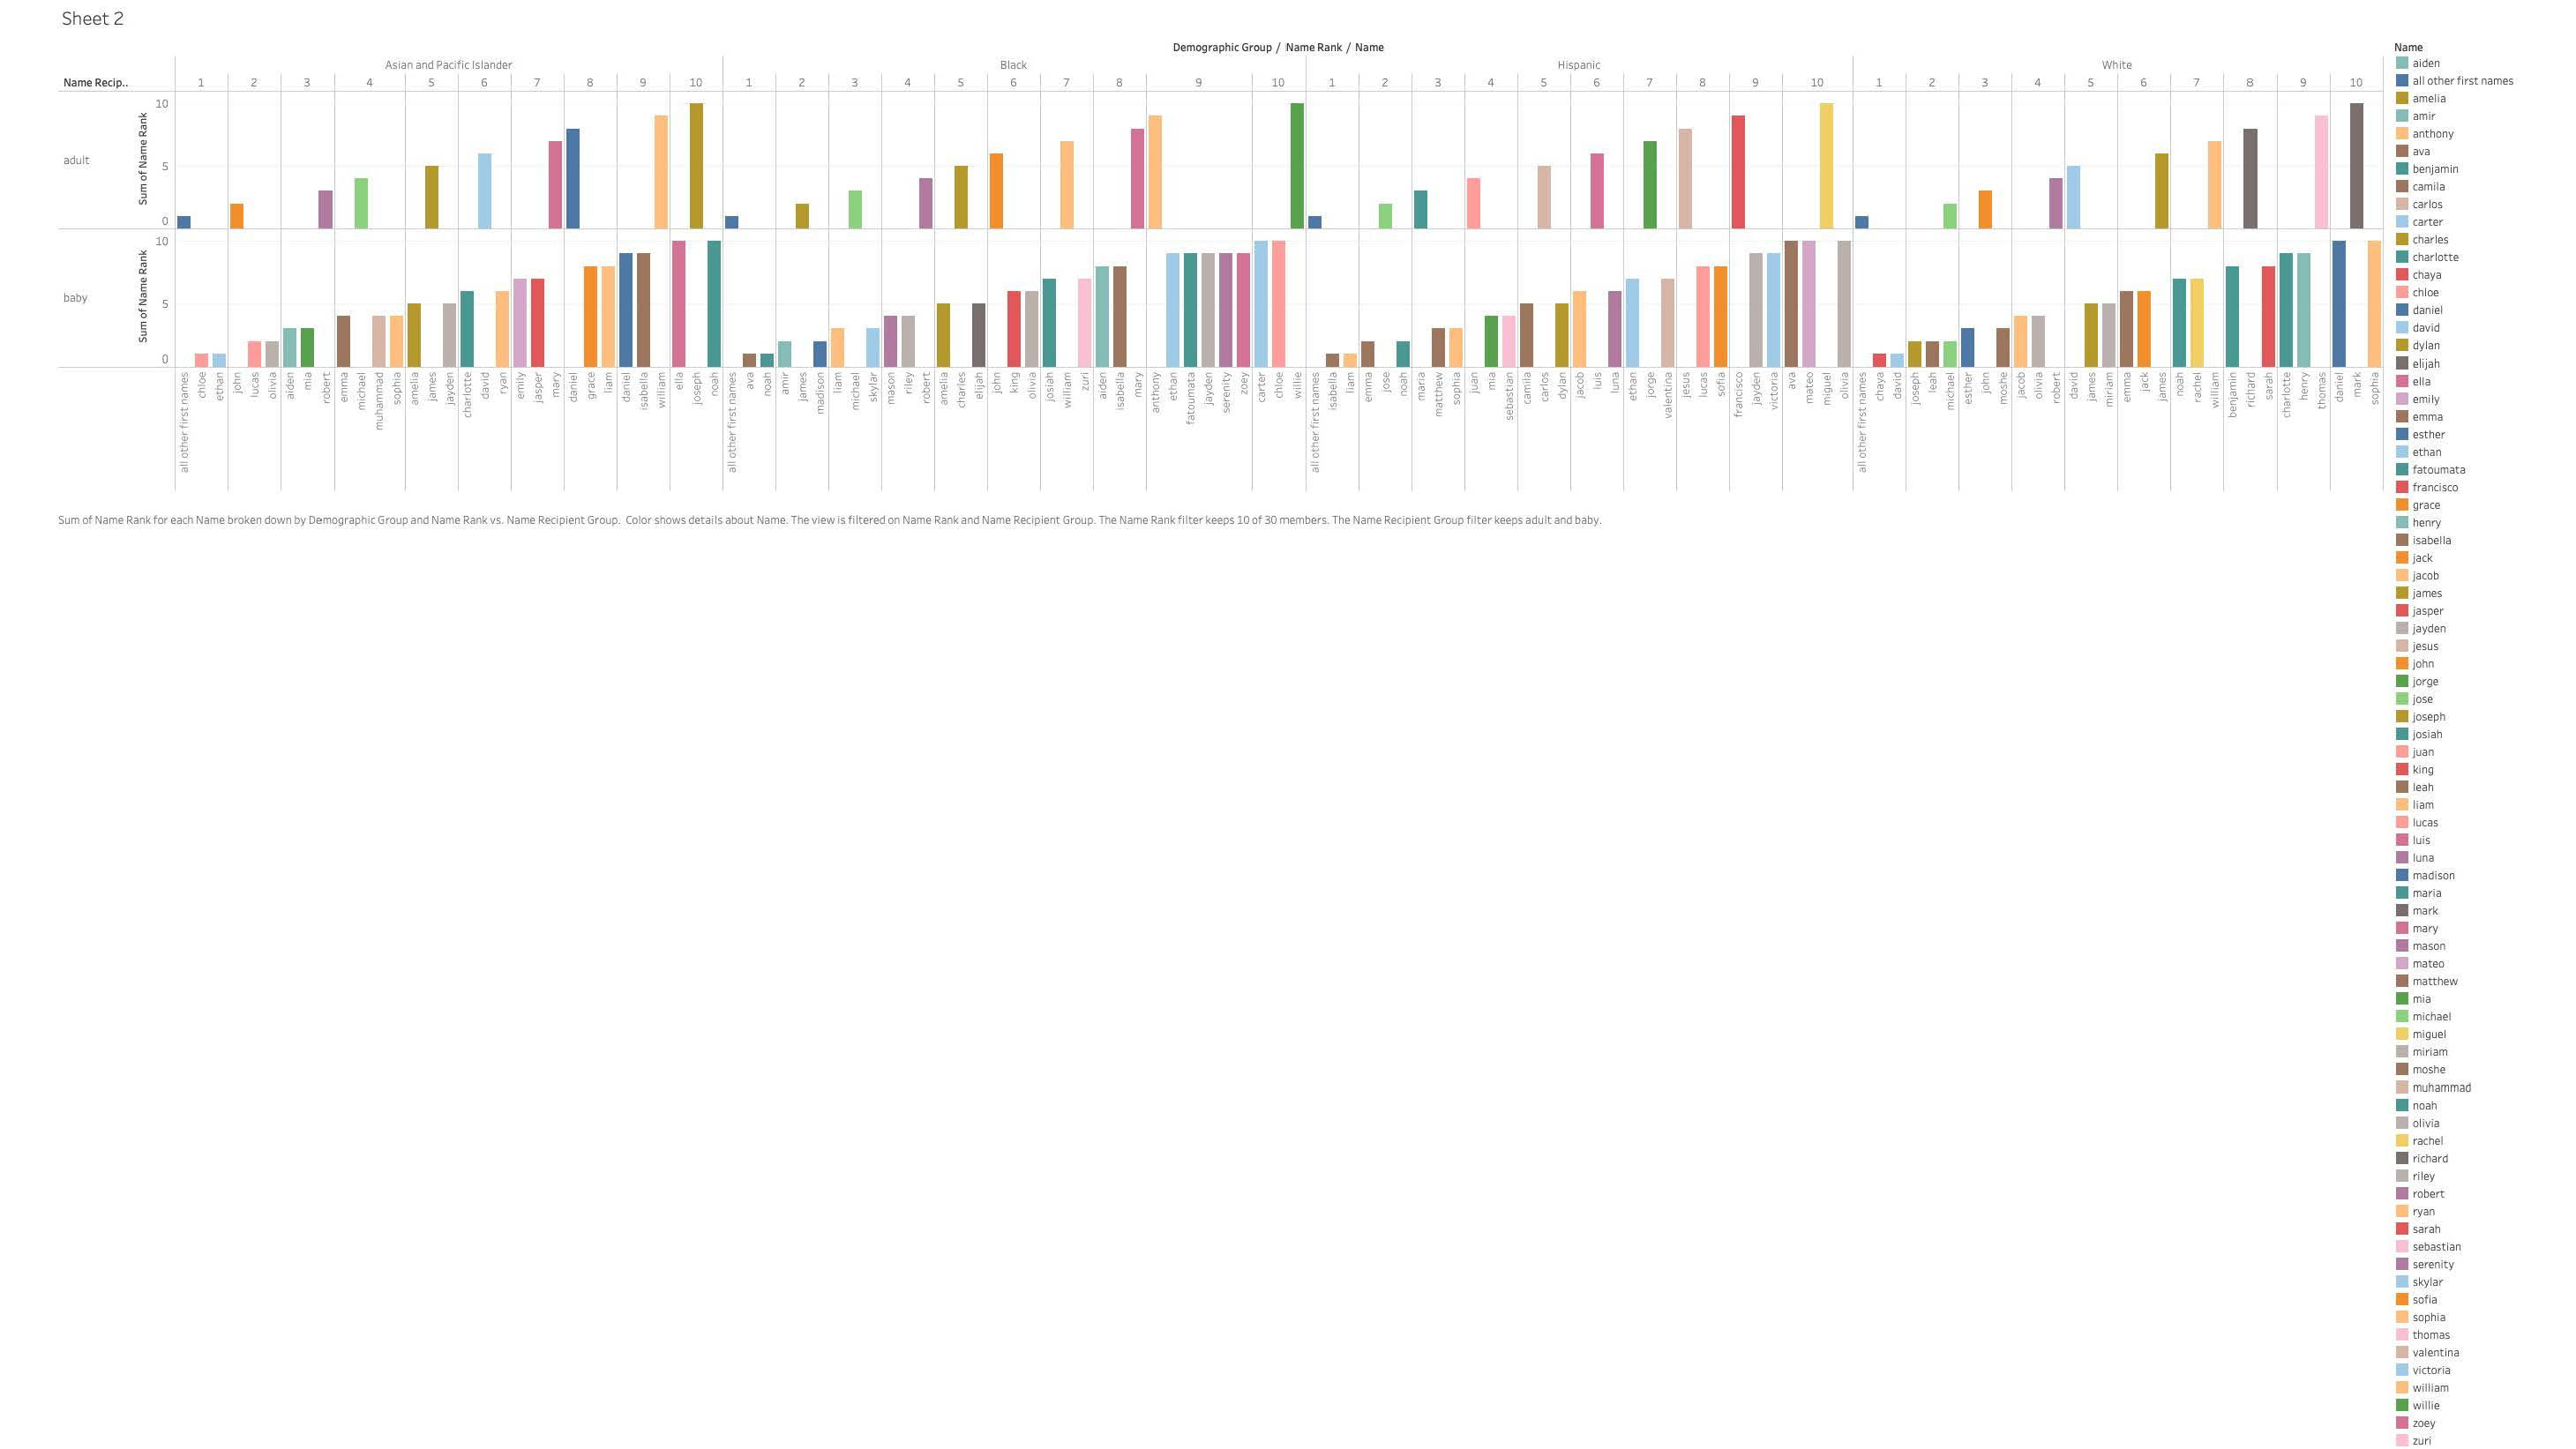

#### Below shows the top 10 populat name from Baby and Dog
According to this chart, we know most people don't use the same name with their baby and dog.
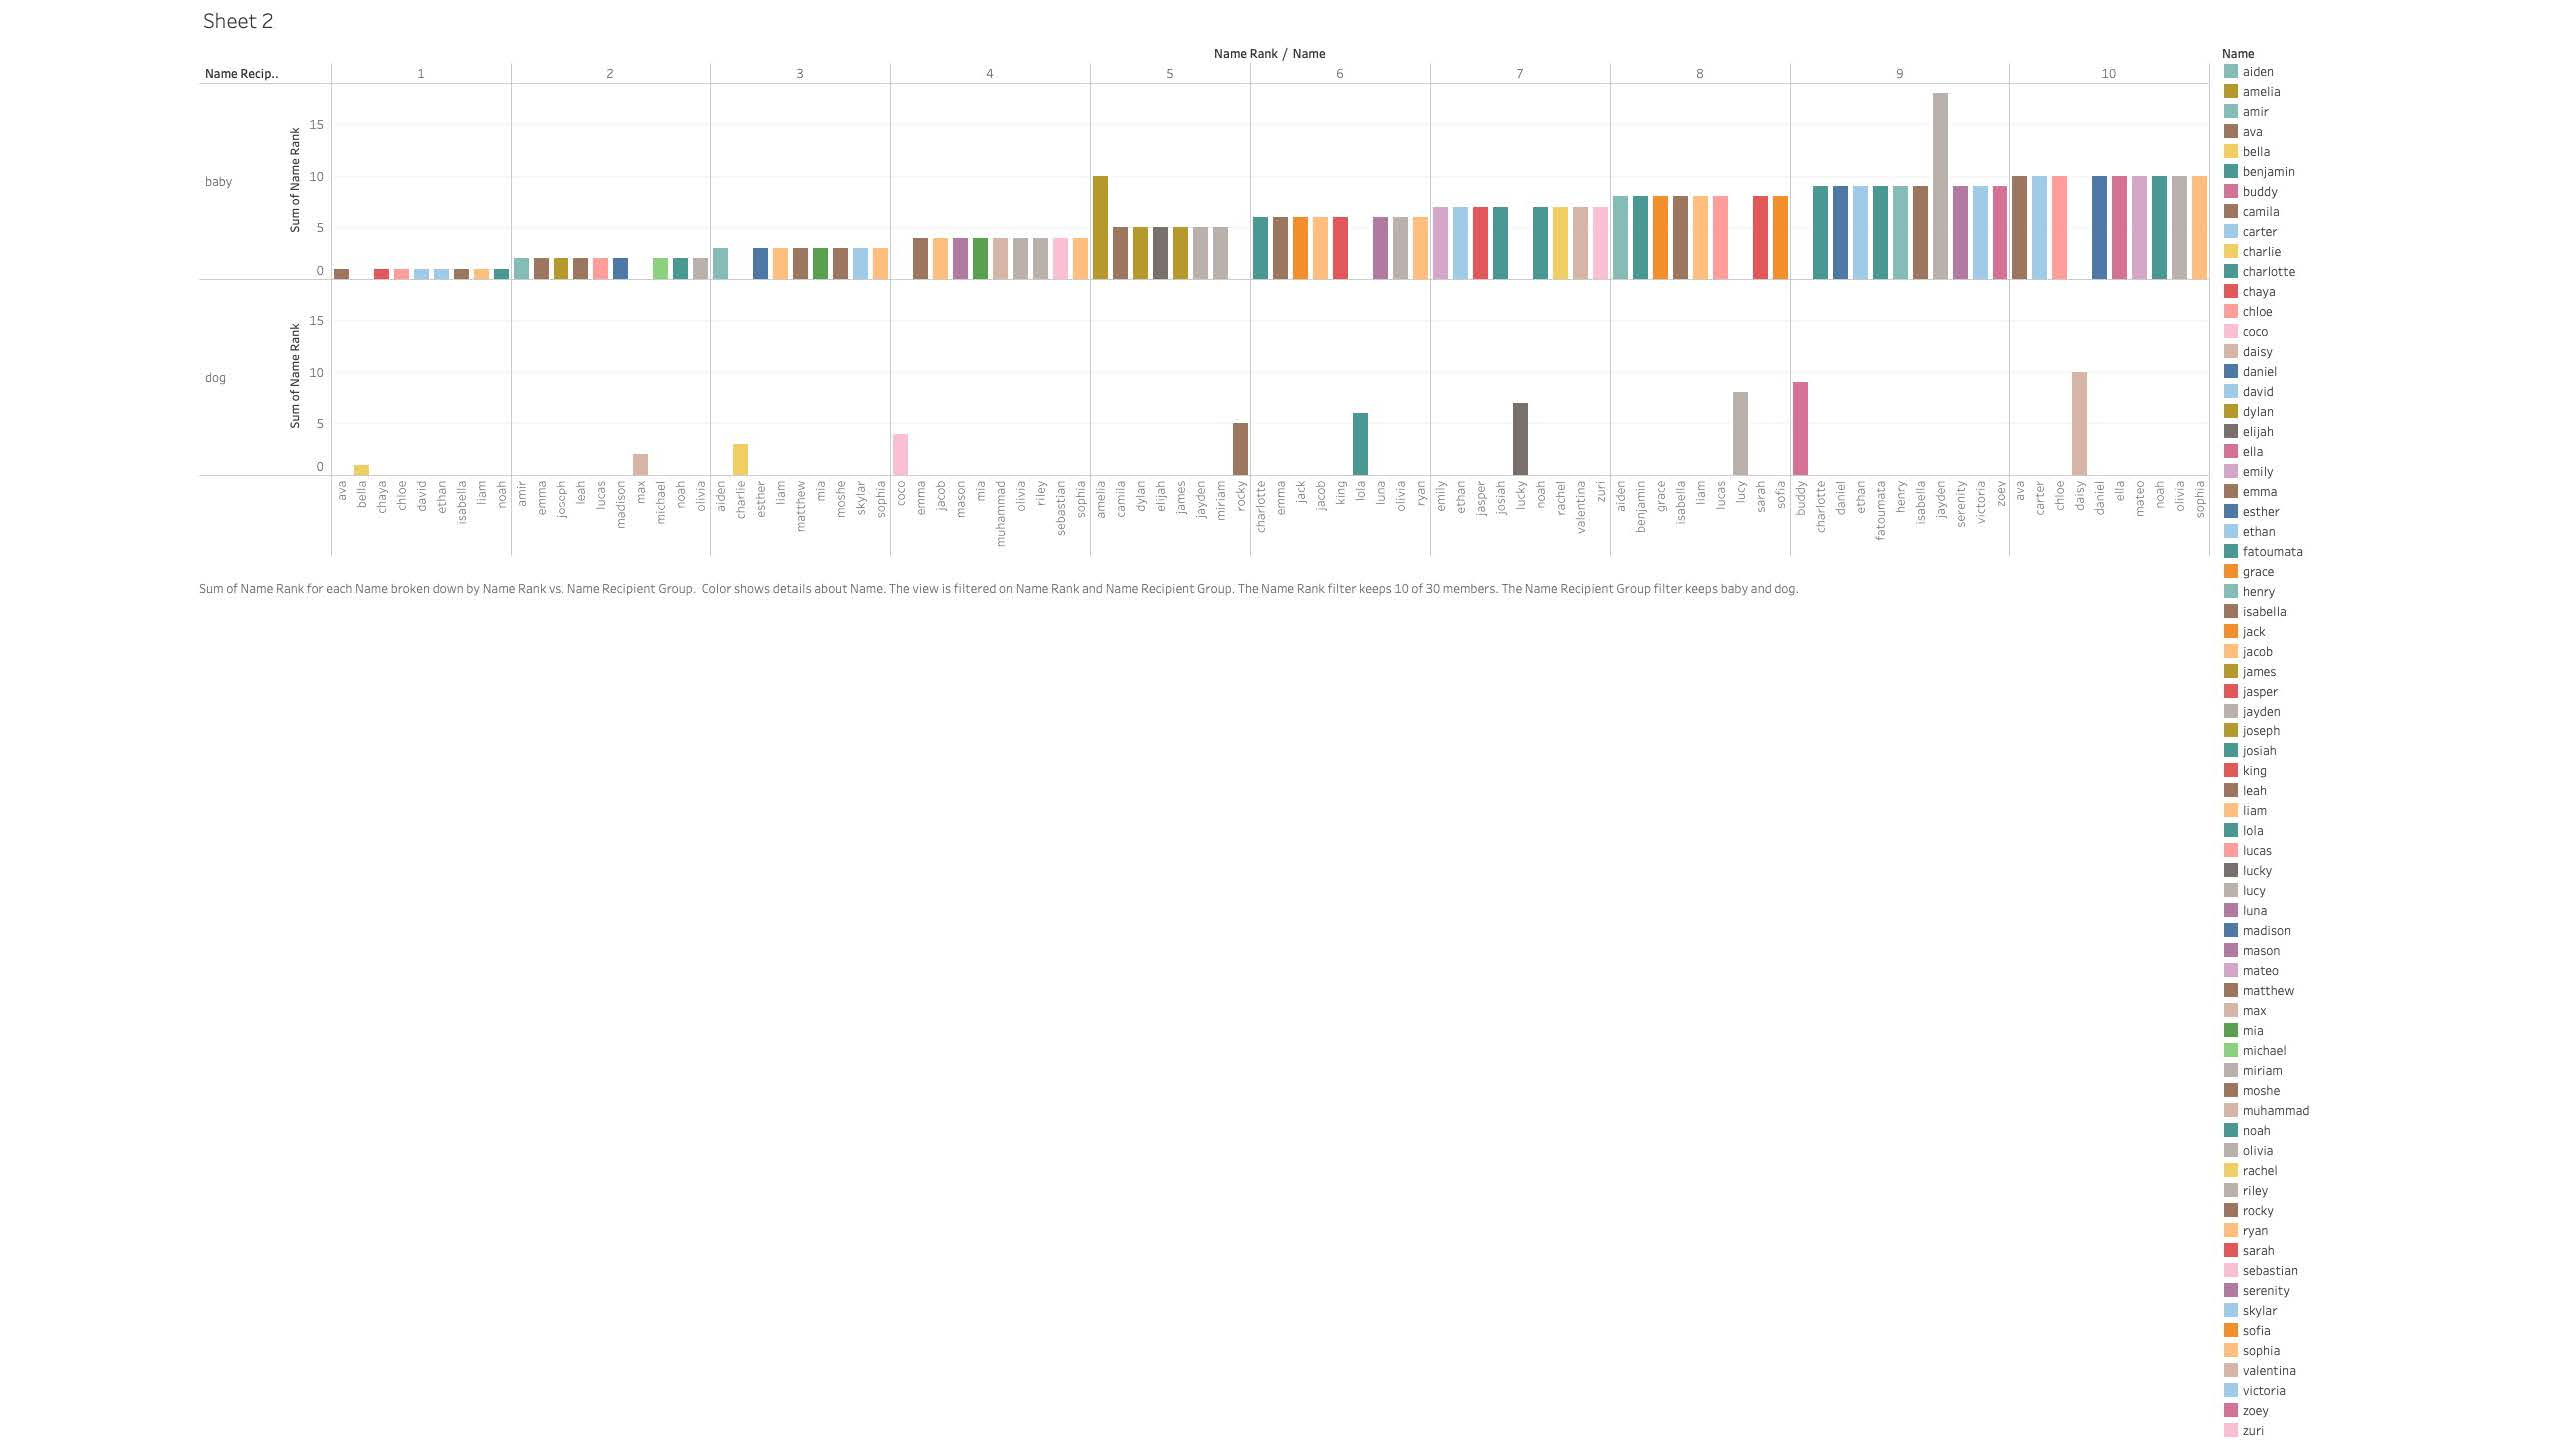

#### Below shows the top 10 populat name from Baby and Dog
This chart also shows the top 10 from each (Adult, Baby and Dog) group without mentioning the rank. Therefore, we can see there are some shared names both popular in adults and babies but not exactly with the same rank.
For example, Daniel and James are both very popular in Adult and Baby but none of them are popular in Dog Names.
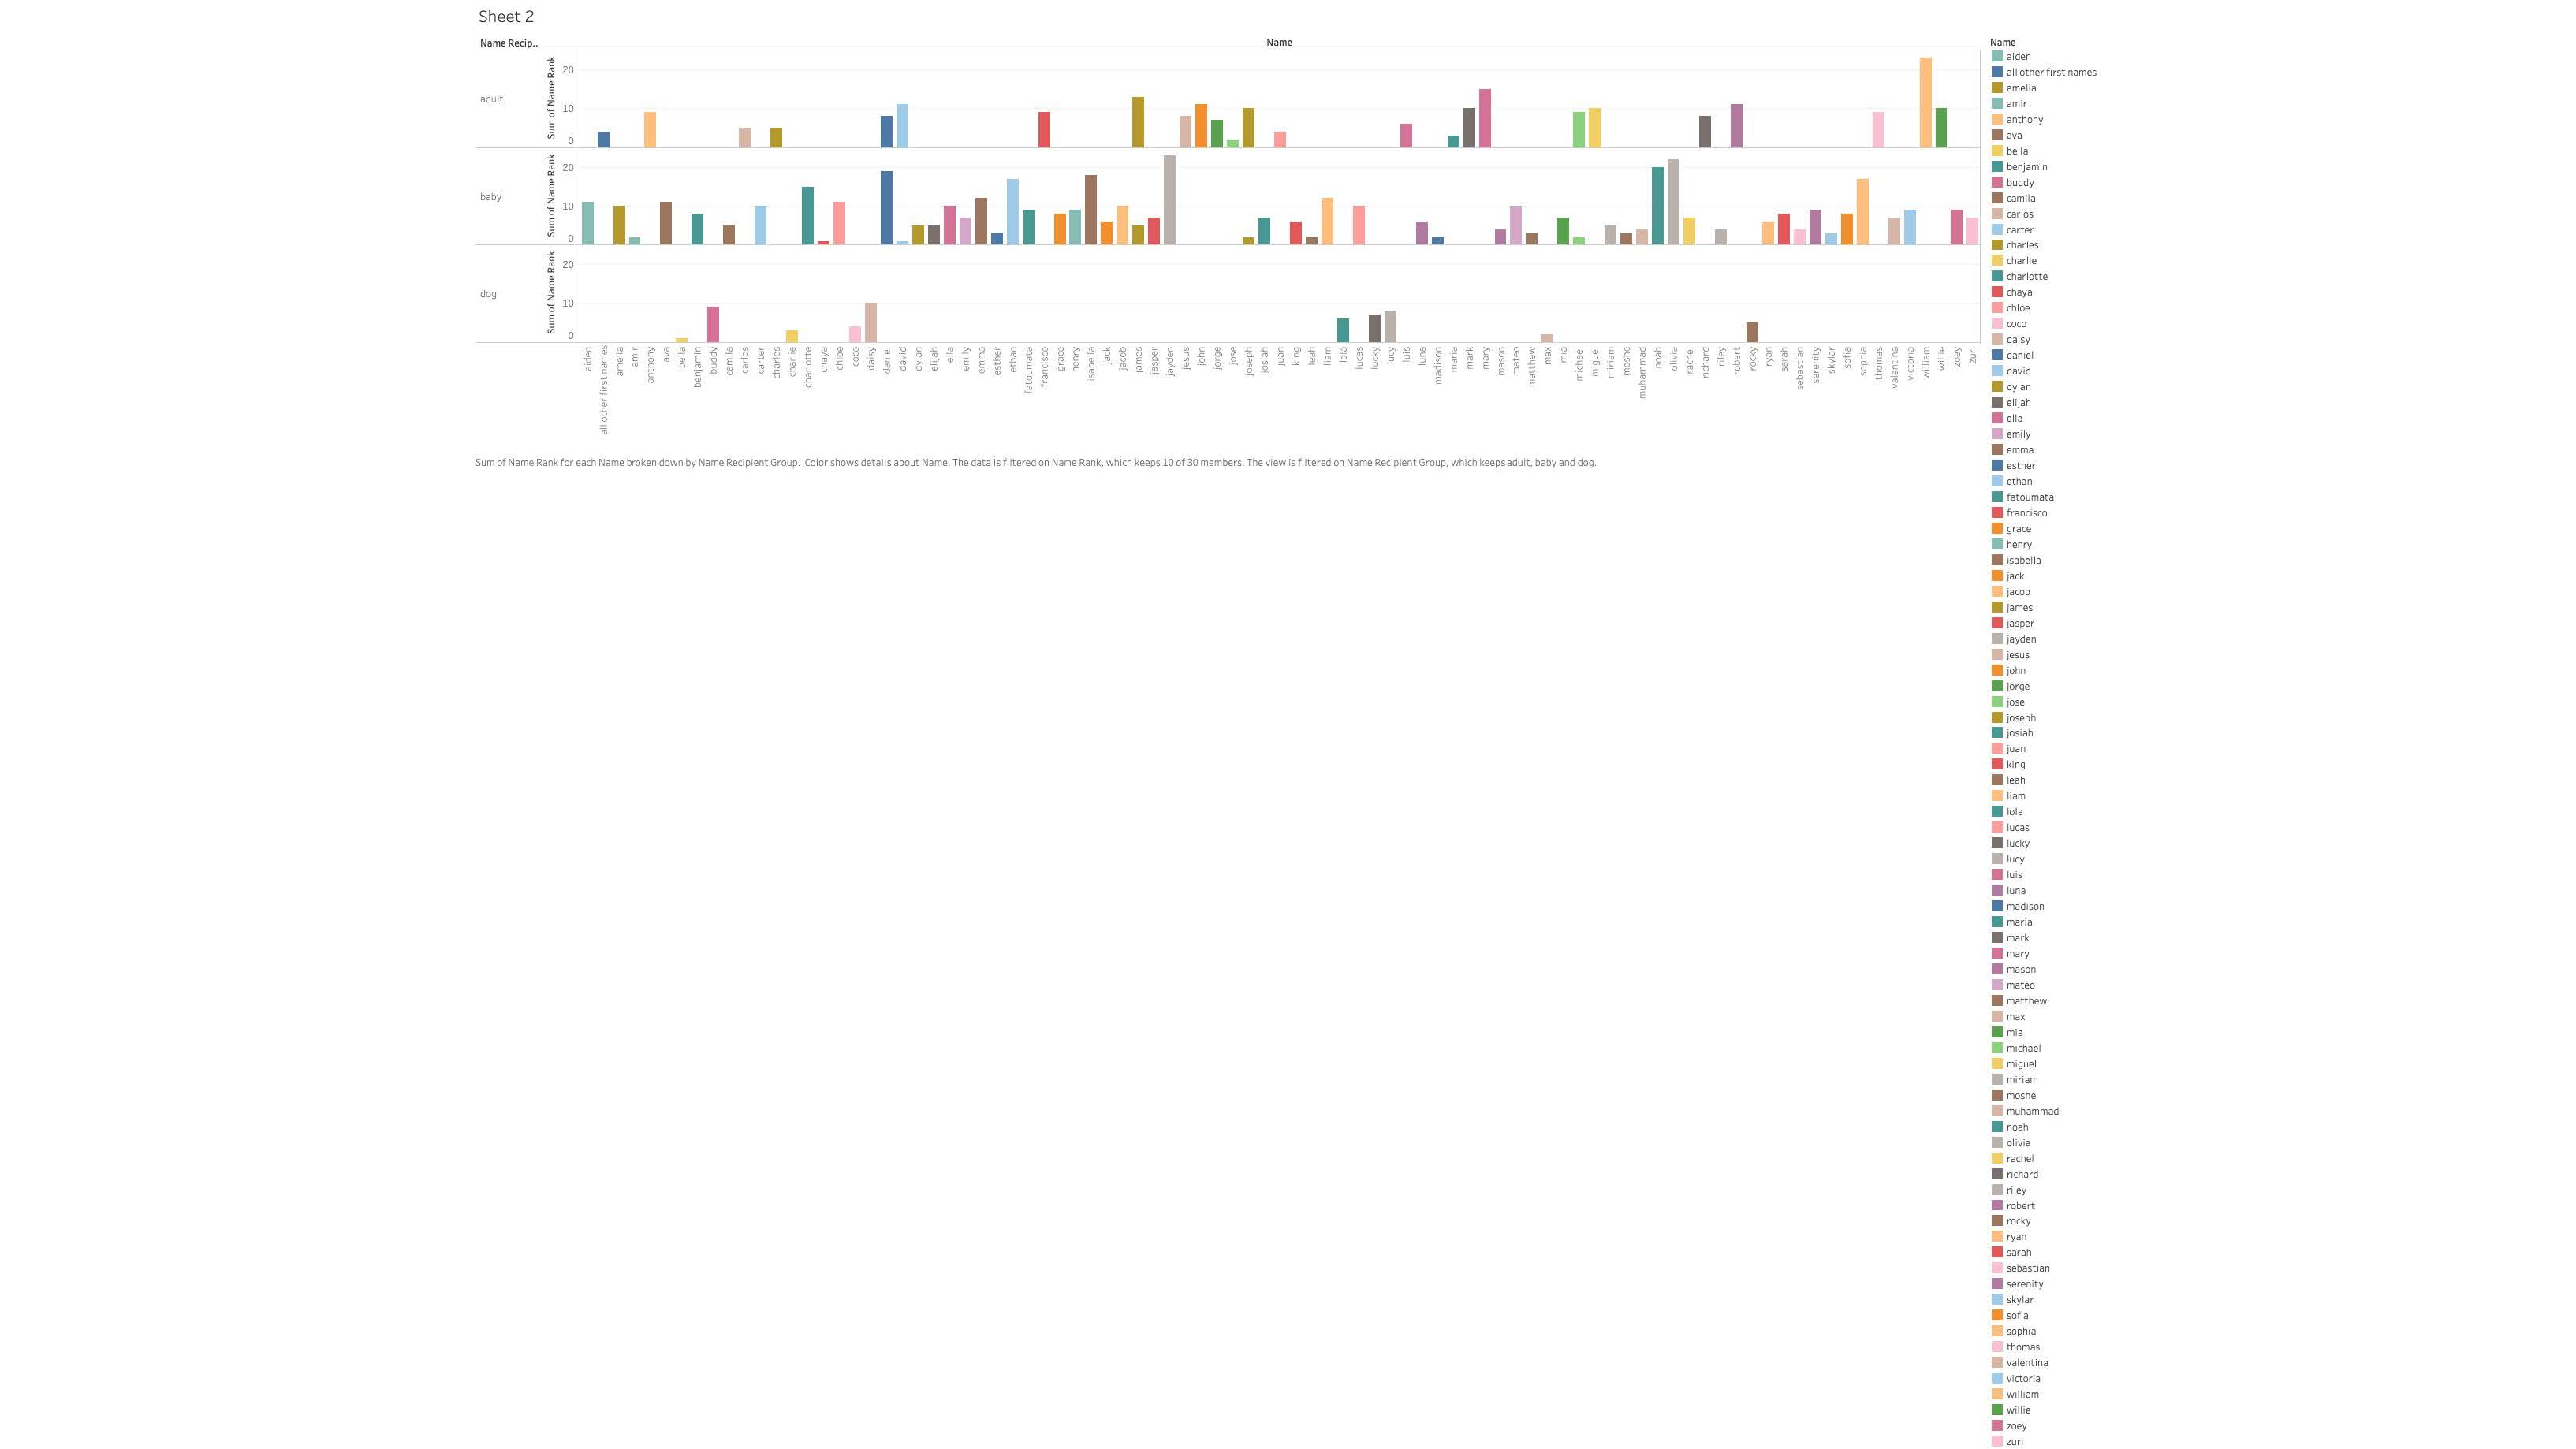

#### Conclution
Specifically, we wanted to find if there were any changes in name trends. After the analysis, I confirmed that the naming trend has changed for all races and ethnicities. The majority of the most popular names for adults are no longer popular for the name for Baby.
Besides, some of the names that are often used for a dog do not even exist for a human name (both adult and baby). Therefore, we also knew that people used different names when naming their fur babies and had no corelation. 

### Challenge We Faced:

We had encountered many challenges from the beginning when we designed our ER diagram until the last second. The most straightforward step is exporting the data to a new csv file. However, we listed some challenges we encountered and solve them step by step.

The first challenge was the er diagram. We were confused about converting all the data sourcing and breaking it into tables. We did not know how to make data from columns into attributes. We figured out that by understanding the "Primary Key" and "Foreign Key" first and knowing what table we need, then we will receive more explicit pictures of the er diagram. 

The second challenge we faced in building our own database into the environment `%env DATABASE_URL=postgresql://localhost/vp_database1` The first approach was failed because we used the wrong environment. However, the environment was built successfully after inputting a new name to create an individual database. 

The third challenge had the count from each group in adult names. After importing all the attributes into the name_popularity table, we realized that the way the "FirstNames.csv" shows the ethnicity in different columns by a portion of people who use that name. It's another method of the way it displays the collecting data than "BabyNames.csv". Therefore, we wrote a for loop statement to check if the CSVReader reads the particular ethnicity, then it will return the portion of the name used for a particular group.

Forth, after we imported all the data into 4 tables and started doing the queries, we figured out that the data we received contained some duplicated rows and some errors. It caused that we will receive the same name, name_id with the exact count and demographic group. We need to group it by name_id to see a clean and organized output. Therefore, it pulls us back to re-import the data again by merging the counts of all the duplicated rows. We used an `if` statement to check if the cursor has already read the row or the name; if so, we sum up the count. We did not throw away the duplicate row because we think it might be a mistake, but people who do this dataset forgot to merge then. 

### What We Learned:

Data Cleaning.
I have trouble with the data because we didn't check the data at the beginning. If we clean the data earlier, then we won't need to write and if loop to check the duplication. Therefore, having clean data will ultimately increase overall productivity and allow for the highest quality information in our results.

Searching method on W3Schools.
During the process, we encounter a few issues that we did not learn about before. Therefore, we need to self-taught the writing skills in Python to solve our problem and debug the error. We pretty much enjoy the progress and what we learned after finishing the analysis, especially seeking a method by using online tools will become really useful skills in our future careers. 

Beyond the analysis progress itself, we enjoy the results output of knowing the name trend.